### Agentic RAG

1. retrieve
2. generate
3. rewrite
4. 문서 검증

### Conditional Edge

- 조건부 실행 흐름을 제어하는 Edge
- 특정 조건 충족시에만 해당 경로로 실행 진행
- LLM의 판단에 따라 경로 제어

공식문서를 따라가면 rewrite를 정상적으로 하지 않아 살짝 변형

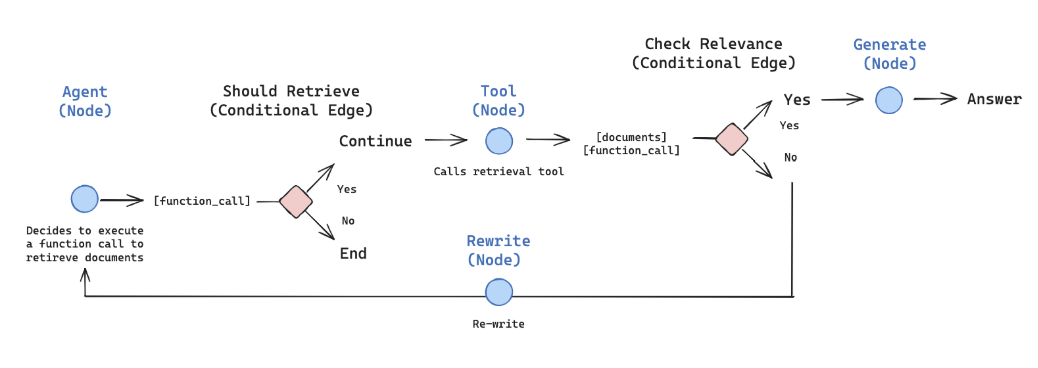

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})


- state 선언 후 Agent 생성

In [6]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [8]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환
    """
    query = state['query']  # state에서 사용자의 질문을 추출
    docs = retriever.invoke(query)  # 질문과 관련된 문서를 검색
    return {'context': docs}  # 검색된 문서를 포함한 state를 반환


In [9]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

- LangSmith에서 제공하는 여러가지 프롬프트 사용

In [10]:
from langchain import hub

# RAG 프롬프트 가져오기
generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    context = state['context']  # state에서 문맥 추출
    query = state['query']      # state에서 사용자의 질문 추출
    
    # RAG 체인 구성
    rag_chain = generate_prompt | llm
    
    # 질문과 문맥을 사용하여 응답 생성
    response = rag_chain.invoke({'question': query, 'context': context})
    
    return {'answer': response}  # 생성된 응답을 포함하는 state 반환


/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


- conditional_edge를 활용하여 문서 관련성을 판단하는 로직 구현
    - Agent는 LLM의 판단과 의사결정을 따릅니다.



In [11]:
from langchain import hub
from typing import Literal

# 문서 관련성 판단을 위한 프롬프트 가져오기
doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    """
    주어진 state를 기반으로 문서의 관련성 판단

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['generate', 'rewrite']: 문서가 관련성이 높으면 'generate', 그렇지 않으면 'rewrite' 반환
    """
    query = state['query']  # state에서 사용자의 질문 추출
    context = state['context']  # state에서 문맥 추출

    # 문서 관련성 판단 체인 구성
    doc_relevance_chain = doc_relevance_prompt | llm
    
    # 질문과 문맥을 사용하여 문서의 관련성 판단
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    # 관련성이 높으면 'generate' 반환, 그렇지 않으면 'rewrite' 반환
    if response['Score'] == 1:
        return 'generate'
    
    return 'rewrite'

/opt/homebrew/lib/python3.11/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [12]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 사전 정의: 특정 표현을 다른 표현으로 변환하기 위한 사전
dictionary = ['사람과 관련된 표현 -> 거주자']

# 프롬프트 템플릿 생성 / 사용자의 질문을 사전을 참고하여 변경
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환
    """
    query = state['query']  # state에서 사용자의 질문 추출
    
    # 리라이트 체인 구성 / 프롬프트, LLM, 출력 파서 연결
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    # 질문 변경
    response = rewrite_chain.invoke({'query': query})
    
    return {'query': response}  # 변경된 질문을 포함하는 state 반환

- node를 추가하고 edge로 연결

In [13]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

- Runnable -> 따옴표 X

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

- 대부분의 노드는 state를 반환
- check_doc_relevance는 다음 경로를 반환 (다음 노드의 이름)

In [15]:
graph = graph_builder.compile()

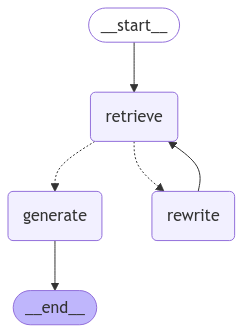

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_state = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_state)

{'query': '연봉 5천만원 세금',
 'context': [Document(id='4694122e-ef53-4812-abe9-5b8a79ba1ba0', metadata={'source': './documents/income_tax.txt'}, page_content='환산금여에 따라 정한 다음의 금액'),
  Document(id='df2765ce-6239-4ea0-9d4f-8eeafccd2c8c', metadata={'source': './documents/income_tax.txt'}, page_content='2. 남세무와 관련 세무서장이 제조하기 같은 경우에는 지세에 대해 직접 과세기간의 소득세에 대한 환급신청할 수 있어야 한다.\n   (가) 제정법에 제83항과 규정을 해 당 거주자가 제70조, 제70조 또는 제74조에 면세인 소기업자 결합금 발생한 과세기간과 직접 과세기간의 소득에 대한 소득세로 미안 세액이다. <개정 2012. 1. 1., 2014. 1. 1., 2021. 12. 31.>\n3. 제47조제5항 각 호의 소득(고교 학 제3호의 이자소득과 같은 제80조의 원천징수 대상소득 중 대통합령으로 정하는 사업소득을 제외하되 대한 원천징수세액에 1천만 미만인 경우\n   <개정 2012. 1. 1., 2013. 1. 1.>  \n법제처\n61\n국가법령정보센터'),
  Document(id='d33c7f26-c912-498e-baf6-cb3628a2fcf5', metadata={'source': './documents/income_tax.txt'}, page_content='나. 사유제<2014. 12. 23.>\n다. 사망할 때까지 연금수령하는 대통령령으로 정하는 중심계좌에 따라 받는 연금소득에 대해서는 100분의 4\n5) 제20조제3제1항제2호에 따라 퇴직소득을 연금수령하는 연금소득에 대해서는 다음 각 목의 구분에 따른 세율. 이 경우 연금 실지 수령액 및 연금수령 원천징수세율의 구체적인 내용은 대통령령으로 정한다.\n    가. 연